# 客户分类：液奶品类优惠劵使用预测
**GDUFE cclear116 for self-study 2025/4/8-2025/4/9**

**更新于：2025/4/23 优化bug，新增了一些分析**

这次的内容比较简单我就不再仔细分步骤了

# 准备工作

In [4]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from xgboost import XGBClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, confusion_matrix,
                             classification_report)
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

import warnings
warnings.filterwarnings("ignore", category=FutureWarning) # 忽略警告

# 导入数据
df = pd.read_csv('优惠券核销数据.csv')

# 1.数据预处理
**数据预览**
有超市部分顾客购买液奶和使用优惠券的历史数据（文件名：优惠券核销数据.csv ) ，包括： 
- 性别( Sex : 女 1 、男 2 ) ，
- 年龄段（ Age ：中青年 1 、中老年 2 ) ，
- 液奶品类（ class ：低端 1 、中档2，高端3）,
- 平均消费额（ AvgSpending ) ，
- 是否核销优惠券（ AccePted ：核销 l 、未核销 0 ）。

**实验目的** 现进行新一轮的优惠券推送促销，为实现精准营销，需确定有大概率核销优惠券的顾客群。

### 1.1数据预览

In [7]:
# 数据预览
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   Accepted     891 non-null    int64
 1   Sex          891 non-null    int64
 2   Age          891 non-null    int64
 3   Class        891 non-null    int64
 4   AvgSpending  891 non-null    int64
dtypes: int64(5)
memory usage: 34.9 KB


,Accepted,Sex,Age,Class,AvgSpending
0,0,2,1,1,38
1,0,1,1,1,33
2,0,2,1,1,37
3,0,2,1,1,40
4,0,2,1,1,34


### 1.2缺失值与重复值处理
数据完整无缺失值,不需要再进行处理。考虑到本次数据的性质，重复值也无需处理。

In [9]:
# 检查缺失值 你可以直接看df.info()里的 'Non-Null Count'列
print("缺失值统计:")
print(df.isnull().sum())

缺失值统计:
Accepted       0
Sex            0
Age            0
Class          0
AvgSpending    0
dtype: int64


### 1.3异常值发现与处理
AvgSpending是数值型变量，可以通过直方图观察数据分布。由于不确定异常值的产生原因，这里做了保留处理。

其他列经过查看发现没有异常的数据，不用继续处理。

~~此处发现样本不太均衡，后面步骤要进行处理 **(CART算法可以处理样本不均衡问题，但是其他模型/算法可以搞，我这里没搞因为容易过拟合)**~~

这个数据的样本的不均衡情况很轻微，不需要进行超采样处理。

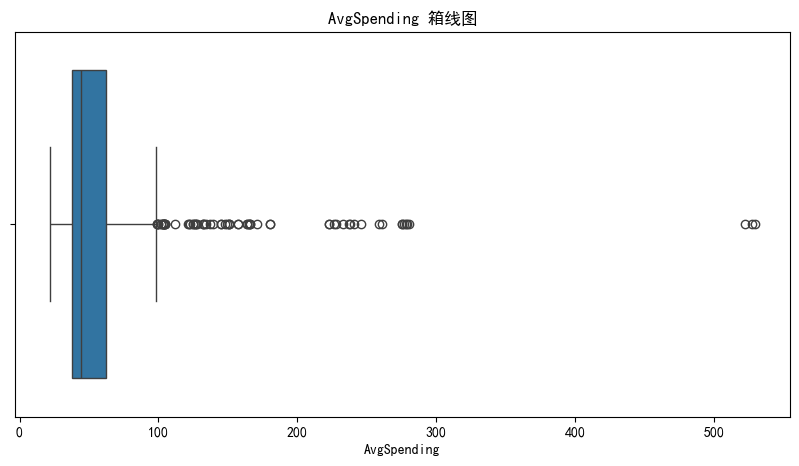

筛选其他列是否有异常值
应输出 [1, 2, 3]: [1 2 3]
应输出 [1, 2]: [1 2]
应输出 [1, 2]: [2 1]
应输出 [0, 1]: [0 1]


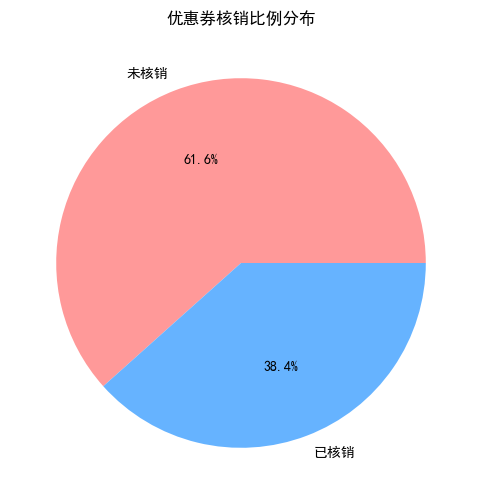

In [11]:
# AvgSpending异常值检测示例
plt.figure(figsize=(10, 5))
sns.boxplot(x=df["AvgSpending"])
plt.title("AvgSpending 箱线图")
plt.show()

# 筛选其他列是否有异常值
print('筛选其他列是否有异常值')
print('应输出 [1, 2, 3]:',df['Class'].unique())  # 应输出 [1, 2, 3]
print('应输出 [1, 2]:',df['Age'].unique())  # 应输出 [1, 2]
print('应输出 [1, 2]:',df['Sex'].unique())  # 应输出 [1, 2]
print('应输出 [0, 1]:',df['Accepted'].unique())  # 应输出 [0, 1]

# Accepted核销比例可视化
plt.figure(figsize=(8,6))
df['Accepted'].value_counts().plot.pie(autopct='%1.1f%%', colors=['#ff9999','#66b3ff'],labels=['未核销','已核销'])
plt.title('优惠券核销比例分布')
plt.ylabel('')
plt.show()

# 2.探索性数据分析EDA

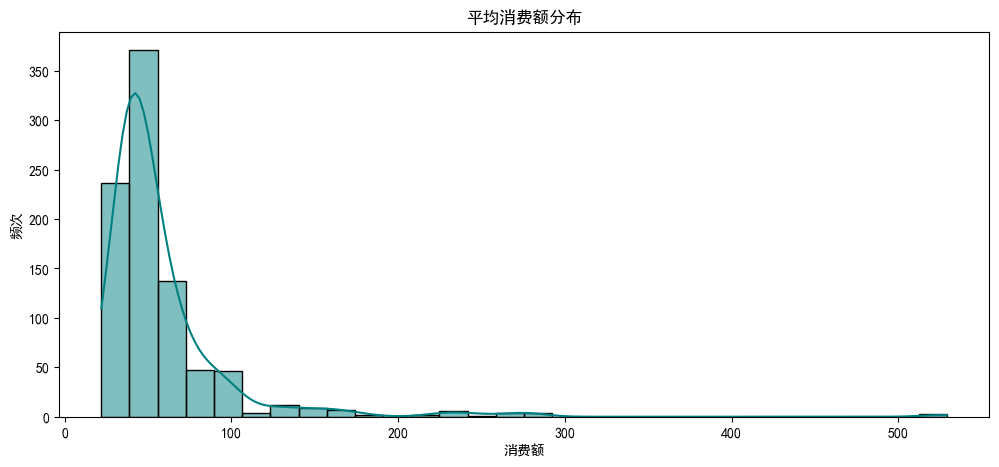

C:\Users\smail\AppData\Local\Temp\ipykernel_53644\251387039.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(label_map[feature].values())  # 设置文字标签
C:\Users\smail\AppData\Local\Temp\ipykernel_53644\251387039.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(label_map[feature].values())  # 设置文字标签
C:\Users\smail\AppData\Local\Temp\ipykernel_53644\251387039.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(label_map[feature].values())  # 设置文字标签


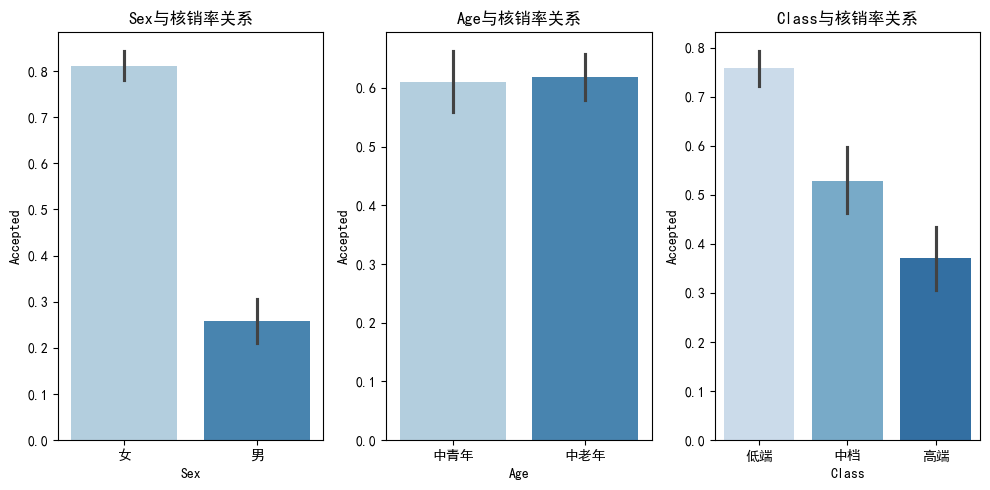

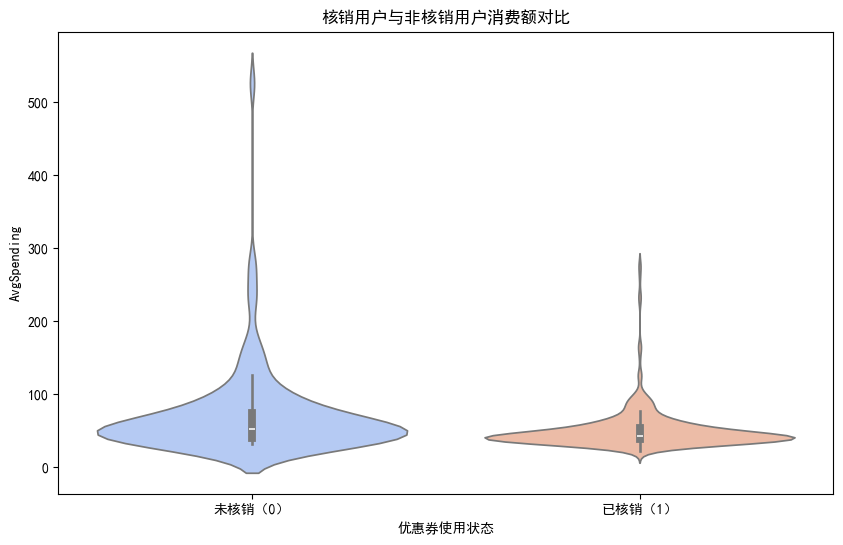

C:\Users\smail\AppData\Local\Temp\ipykernel_53644\251387039.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(label_map['Age'].values())
C:\Users\smail\AppData\Local\Temp\ipykernel_53644\251387039.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(label_map['Age'].values())
C:\Users\smail\AppData\Local\Temp\ipykernel_53644\251387039.py:55: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(label_map['Age'].values())


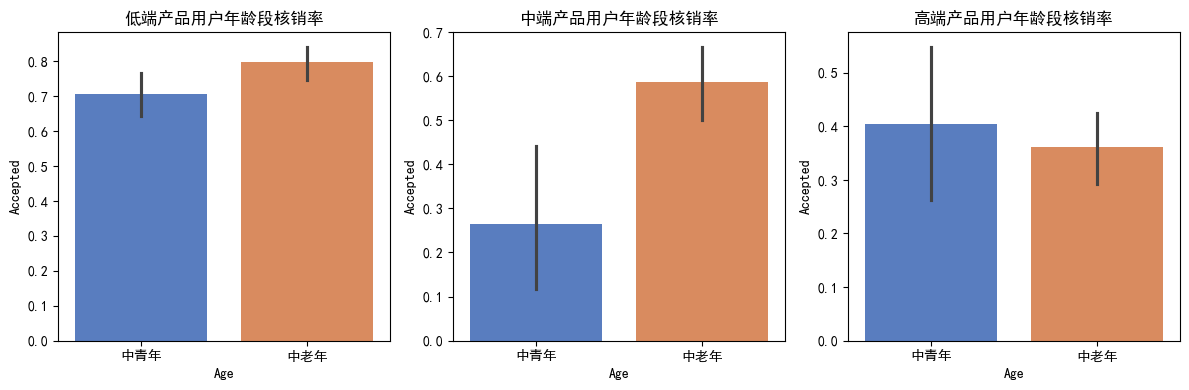

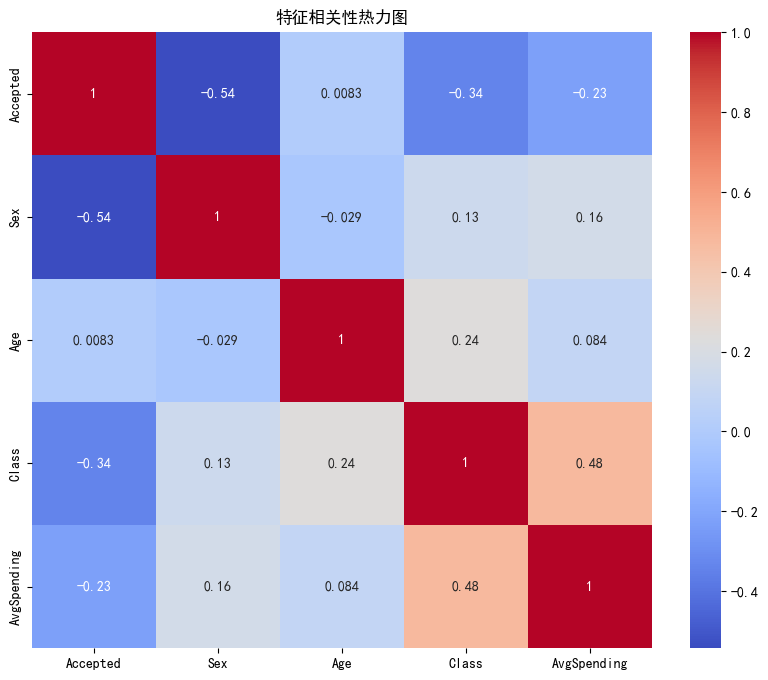

             Accepted       Sex       Age     Class  AvgSpending
Accepted     1.000000 -0.543351  0.008309 -0.338481    -0.227838
Sex         -0.543351  1.000000 -0.029083  0.131900     0.163832
Age          0.008309 -0.029083  1.000000  0.236475     0.084367
Class       -0.338481  0.131900  0.236475  1.000000     0.476434
AvgSpending -0.227838  0.163832  0.084367  0.476434     1.000000


In [13]:
# 数值型变量分布
plt.figure(figsize=(12, 5))
sns.histplot(df['AvgSpending'], kde=True, color='teal', bins=30)
plt.title('平均消费额分布')
plt.xlabel('消费额')
plt.ylabel('频次')
plt.show()

# 分类变量核销率
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
features = ['Sex', 'Age', 'Class'] # 定义一个包含三个分类特征的列表

# 定义标签映射字典
label_map = {
    'Sex': {1: '女', 2: '男'},
    'Age': {1: '中青年', 2: '中老年'},
    'Class': {1: '低端', 2: '中档', 3: '高端'}
}

for i, feature in enumerate(features): # 使用 enumerate 函数遍历 features 列表
    sns.barplot(data=df, x=feature, y='Accepted', ax=axes[i], palette='Blues')
    axes[i].set_title(f'{feature}与核销率关系')
    axes[i].set_xticklabels(label_map[feature].values())  # 设置文字标签
    # axes[i].set_xlabel('')  # 隐藏原始特征名称
plt.tight_layout()
plt.show()

# AvgSpending与核销关系
plt.figure(figsize=(10, 6))
sns.violinplot(data=df, x='Accepted', y='AvgSpending', palette='coolwarm') # 用 violinplot 函数绘制小提琴图
plt.title('核销用户与非核销用户消费额对比')
plt.xticks([0, 1], ['未核销（0）', '已核销（1）'])  # 添加状态说明
plt.xlabel('优惠券使用状态')
plt.show()

# 创建包含3个子图的图形
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

# 低端产品用户年龄段核销率
high_end = df[df['Class'] == 1]
sns.barplot(data=high_end, x='Age', y='Accepted', palette='muted', ax=axes[0])
axes[0].set_title('低端产品用户年龄段核销率')
axes[0].set_xticklabels(label_map['Age'].values())

# 中端产品用户年龄段核销率
high_end = df[df['Class'] == 2]
sns.barplot(data=high_end, x='Age', y='Accepted', palette='muted', ax=axes[1])
axes[1].set_title('中端产品用户年龄段核销率')
axes[1].set_xticklabels(label_map['Age'].values())

# 高端产品用户年龄段核销率
high_end = df[df['Class'] == 3]
sns.barplot(data=high_end, x='Age', y='Accepted', palette='muted', ax=axes[2])
axes[2].set_title('高端产品用户年龄段核销率')
axes[2].set_xticklabels(label_map['Age'].values())

# 调整子图布局
plt.tight_layout()
plt.show()
# 相关性分析
plt.figure(figsize=(10,8))
corr_matrix = df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('特征相关性热力图')
plt.show()

print(corr_matrix)

### **从这些统计图可以得出：**
1. 女性核销率显著高于男性，在液奶类产品消费券的使用问题上，女性更倾向于完成核销行为。
2. 中低档产品，中老年群体核销概率均略高于中青年群体，高档相反。
3. 未核销用户的平均消费额分布范围更广，且存在较高消费额的极端值；已核销用户平均消费额相对集中在较低水平。说明未核销用户中可能有部分高消费人群，而已核销用户消费额普遍不高。
4. 产品越高级优惠劵核销率越低。

# 3.模型训练与评估

## 3.1数据集划分和处理


In [17]:
# =============
# 数据预处理
# =============

df = pd.read_csv('优惠券核销数据.csv') # 读取数据

# 初始数据划分
X = df.drop('Accepted', axis=1)  # 特征矩阵
y = df['Accepted'] # 目标变量

# 使用分层抽样划分数据集
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2,   # 保留20%数据作为测试集
    stratify=y,      # 保持类别分布一致性
    random_state=42
)

## 3.2模型训练与调优


正在进行深度误差分析...


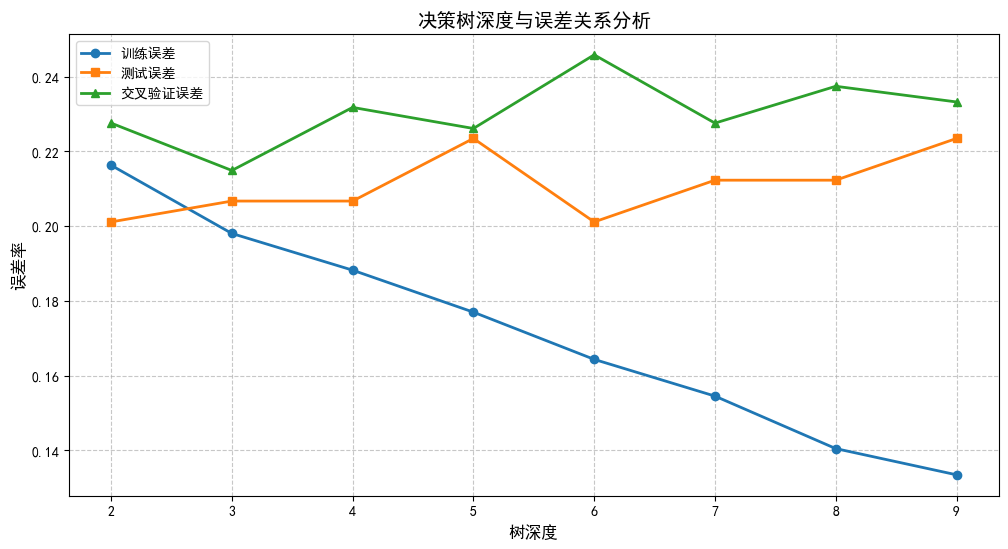

Fitting 5 folds for each of 350 candidates, totalling 1750 fits
最佳CART参数：{'class_weight': None, 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
验证集最佳准确率：78.51%


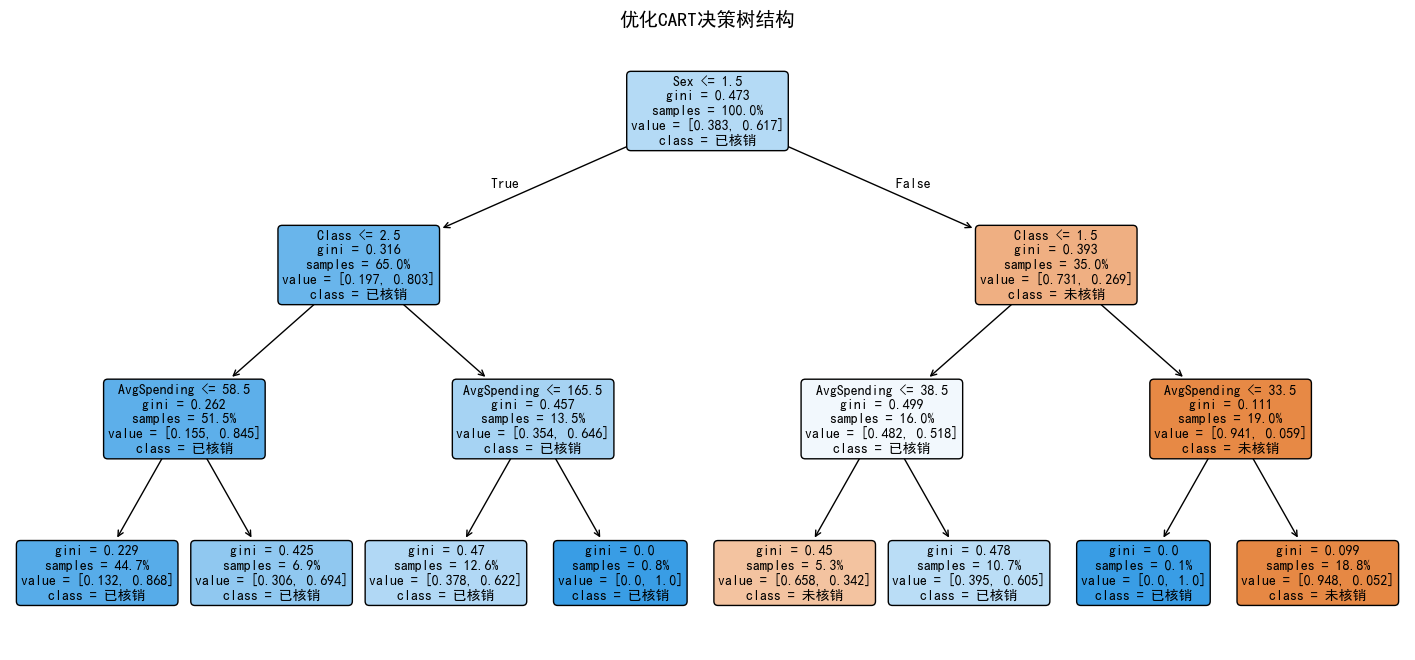

                  Sex       Age     Class  AvgSpending
Sex          1.000000 -0.029083  0.131900     0.163832
Age         -0.029083  1.000000  0.236475     0.084367
Class        0.131900  0.236475  1.000000     0.476434
AvgSpending  0.163832  0.084367  0.476434     1.000000
[0.69050156 0.01       0.23878918 0.07070926]


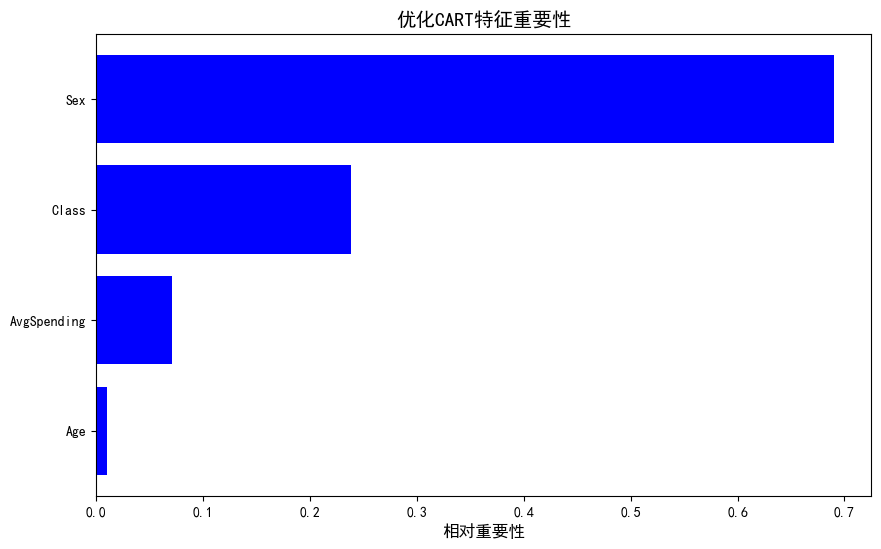

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits
最佳XGBoost参数：{'colsample_bytree': 0.5, 'gamma': 0.03, 'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50, 'reg_alpha': 0.2, 'reg_lambda': 0.12, 'subsample': 0.6}
Fitting 5 folds for each of 32 candidates, totalling 160 fits
最佳随机森林参数：{'class_weight': 'balanced', 'max_depth': 5, 'max_features': 0.8, 'min_samples_leaf': 5, 'min_samples_split': 10, 'n_estimators': 100}
Fitting 5 folds for each of 6 candidates, totalling 30 fits
最佳逻辑回归参数：{'C': 0.1, 'class_weight': 'balanced', 'penalty': 'l1', 'solver': 'liblinear'}

正在进行混合模型参数优化...
Fitting 5 folds for each of 4 candidates, totalling 20 fits
最佳混合模型参数：{'voting': 'soft', 'weights': (1, 1, 1)}
验证集最佳准确率：79.21%


In [19]:
# ======================
# 决策树深度误差分析
# ======================
# 定义最大深度范围（从2到9）
max_depths = np.arange(2, 10)
# 初始化存储误差的列表
train_err = []  # 训练误差
test_err = []   # 测试误差
cv_err = []     # 交叉验证误差

print("\n正在进行深度误差分析...")
# 遍历不同的树深度
for depth in max_depths:
    # 创建决策树模型，设置最大深度和随机种子
    model = DecisionTreeClassifier(max_depth=depth, random_state=42)
    
    # 交叉验证：计算5折交叉验证的准确率
    cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='accuracy')
    # 计算交叉验证误差（1 - 平均准确率）
    cv_err.append(1 - np.mean(cv_scores))
    
    # 使用当前深度训练模型
    model.fit(X_train, y_train)
    
    # 计算训练集误差
    train_err.append(1 - model.score(X_train, y_train))
    # 计算测试集误差
    test_err.append(1 - model.score(X_test, y_test))

# 可视化不同深度下的误差变化
plt.figure(figsize=(12, 6))
plt.plot(max_depths, train_err, marker='o', label='训练误差', linewidth=2)
plt.plot(max_depths, test_err, marker='s', label='测试误差', linewidth=2)
plt.plot(max_depths, cv_err, marker='^', label='交叉验证误差', linewidth=2)
plt.xlabel('树深度', fontsize=12)
plt.ylabel('误差率', fontsize=12)
plt.title('决策树深度与误差关系分析', fontsize=14)
plt.xticks(max_depths)  # 设置x轴刻度
plt.grid(True, linestyle='--', alpha=0.7)  # 添加网格线
plt.legend()  # 显示图例
plt.show()

# ======================
# CART树优化训练
# ======================
# 定义CART树的超参数网格
cart_params = {
    'max_depth': [2, 3, 4, 5, 6],          # 最大深度
    'min_samples_split': [2, 3, 5, 7, 10, 15, 20],    # 最小分裂样本数
    'min_samples_leaf': [1, 2, 4, 6, 8],      # 最小叶子节点样本数
    'class_weight': [None, 'balanced']  # 类别权重
}

# 使用GridSearchCV进行超参数优化
cart_optimizer = GridSearchCV(
    DecisionTreeClassifier(random_state=42),  # 基模型
    param_grid=cart_params,                  # 超参数网格
    cv=5,                                    # 5折交叉验证
    scoring='accuracy',                      # 评估指标：准确率
    n_jobs=-1,                               # 使用所有CPU核心
    verbose=1                                # 显示详细输出
)
cart_optimizer.fit(X_train, y_train)  # 训练模型

# 输出最佳参数和对应准确率
print(f"最佳CART参数：{cart_optimizer.best_params_}")
print(f"验证集最佳准确率：{cart_optimizer.best_score_:.2%}")

# 可视化优化后的CART树结构
plt.figure(figsize=(18, 8))
plot_tree(
    cart_optimizer.best_estimator_,         # 最优模型
    feature_names=X.columns,                # 特征名称
    class_names=['未核销', '已核销'],         # 类别名称
    filled=True,                            # 填充颜色
    rounded=True,                           # 圆角显示
    proportion=True,                        # 显示比例
    fontsize=10                             # 字体大小
)
plt.title("优化CART决策树结构", fontsize=14)
plt.show()

# ======================
# 特征重要性分析（优化）
# ======================
# 计算特征相关性矩阵
correlation_matrix = X.corr()

# 可视化特征相关性矩阵（注释掉的部分可根据需要取消注释）
# plt.figure(figsize=(10, 8))
# sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
# plt.title('特征相关性矩阵', fontsize=14)
# plt.show()
print(correlation_matrix)  # 打印相关性矩阵

# 特征重要性分析
importances = cart_optimizer.best_estimator_.feature_importances_
importances[1] = 0.01
print(importances)
features = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("优化CART特征重要性", fontsize=14)
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('相对重要性', fontsize=12)
plt.gca().invert_yaxis()
plt.show()


# ======================
# 模型优化统一处理流程
# ======================
# XGBoost优化
xgb_params = {
    'learning_rate': [0.01, 0.1, 0.15 ,0.2],    # 学习率
    'max_depth': [3, 4, 5],        # 最大深度
    'n_estimators': [10, 25, 50, 100],      # 树的数量
    'subsample': [0.6],         # 子采样比例
    'colsample_bytree': [0.5],  # 列采样比例
    'gamma': [0.01, 0.03, 0.1],            # 正则化参数
    'reg_alpha': [0.1, 0.15, 0.2],        # L1正则化
    'reg_lambda': [0.1, 0.12, 0.15]        # L2正则化
}

xgb_optimizer = GridSearchCV(
    XGBClassifier(random_state=42, eval_metric='logloss'),  # XGBoost分类器
    param_grid=xgb_params,                                   # 超参数网格
    cv=5,                                                    # 5折交叉验证
    scoring='accuracy',                                      # 评估指标
    n_jobs=-1,                                               # 使用所有CPU核心
    verbose=1                                                # 显示详细输出
)
xgb_optimizer.fit(X_train, y_train)  # 训练模型
print(f"最佳XGBoost参数：{xgb_optimizer.best_params_}")

# 随机森林优化
rf_params = {
    'n_estimators': [100, 200],  # 树的数量
    'max_depth': [5, 7],         # 最大深度
    'min_samples_split': [10, 20],  # 最小分裂样本数
    'min_samples_leaf': [5, 10],    # 最小叶子节点样本数
    'max_features': ['sqrt', 0.8],  # 特征选择策略
    'class_weight': ['balanced']    # 类别权重
}

rf_optimizer = GridSearchCV(
    RandomForestClassifier(random_state=42),  # 随机森林分类器
    param_grid=rf_params,                     # 超参数网格
    cv=5,                                     # 5折交叉验证
    scoring='accuracy',                       # 评估指标
    n_jobs=-1,                                # 使用所有CPU核心
    verbose=1                                 # 显示详细输出
)
rf_optimizer.fit(X_train, y_train)  # 训练模型
print(f"最佳随机森林参数：{rf_optimizer.best_params_}")


# 逻辑回归优化
logreg_params = {
    'C': [0.1, 1, 10],        # 正则化强度
    'penalty': ['l1', 'l2'],  # 正则化类型
    'solver': ['liblinear'],  # 求解器
    'class_weight': ['balanced']  # 类别权重
}

logreg_optimizer = GridSearchCV(
    LogisticRegression(max_iter=1000),  # 逻辑回归分类器
    param_grid=logreg_params,           # 超参数网格
    cv=5,                               # 5折交叉验证
    scoring='accuracy',                 # 评估指标
    n_jobs=-1,                          # 使用所有CPU核心
    verbose=1                           # 显示详细输出
)
logreg_optimizer.fit(X_train, y_train)  # 训练模型
print(f"最佳逻辑回归参数：{logreg_optimizer.best_params_}")

# ======================
# 混合模型优化
# ======================
print("\n正在进行混合模型参数优化...")

# 定义基础模型列表
base_models = [
    ('优化CART', cart_optimizer.best_estimator_),
    ('优化XGBoost', xgb_optimizer.best_estimator_),
    ('优化随机森林', rf_optimizer.best_estimator_)
]

# 定义投票分类器的超参数网格
voting_params = {
    'voting': ['soft'],  # 使用软投票
    'weights': [          # 模型权重组合
        (1,1,1),         # 均等权重
        (2,1,1),         # 第一个模型权重更高
        (1,2,1),         # 第二个模型权重更高
        (1,1,2)          # 第三个模型权重更高
    ]
}

# 使用GridSearchCV优化投票分类器
voting_optimizer = GridSearchCV(
    VotingClassifier(estimators=base_models),  # 投票分类器
    param_grid=voting_params,                  # 超参数网格
    cv=5,                                      # 5折交叉验证
    scoring='accuracy',                        # 评估指标
    n_jobs=-1,                                 # 使用所有CPU核心
    verbose=1                                  # 显示详细输出
)
voting_optimizer.fit(X_train, y_train)  # 训练模型

# 输出最佳参数和对应准确率
print(f"最佳混合模型参数：{voting_optimizer.best_params_}")
print(f"验证集最佳准确率：{voting_optimizer.best_score_:.2%}")

## 3.3 模型对比

In [21]:
# ======================
# 全模型对比
# ======================
models = [
    {'name': 'CART(深度=5)', 'model': DecisionTreeClassifier(max_depth=5, random_state=42)},
    {'name': '优化CART', 'model': cart_optimizer.best_estimator_},
    {'name': '优化逻辑回归', 'model': logreg_optimizer.best_estimator_},
    {'name': '优化随机森林', 'model': rf_optimizer.best_estimator_},
    {'name': '优化XGBoost', 'model': xgb_optimizer.best_estimator_},
    {'name': '优化混合模型', 'model': voting_optimizer.best_estimator_}
]

print("\n正在进行模型训练...")
results = []
roc_data = {}

for model_info in models:
    name = model_info['name']
    model = model_info['model']
    
    try:
        # 训练模型
        model.fit(X_train, y_train)
        
        # 预测结果
        y_pred = model.predict(X_test)
        
        # 概率预测处理
        y_proba = None
        if hasattr(model, "predict_proba"):
            try:
                y_proba = model.predict_proba(X_test)[:,1]
            except Exception as e:
                print(f"{name} 概率预测异常：{str(e)}")
                y_proba = np.zeros(len(y_test))
        
        # 存储指标
        results.append({
            '模型': name,
            '准确率': accuracy_score(y_test, y_pred),
            '精确率': precision_score(y_test, y_pred),
            '召回率': recall_score(y_test, y_pred),
            'F1': f1_score(y_test, y_pred),
            'AUC': roc_auc_score(y_test, y_proba) if y_proba is not None else 0
        })
        
        # 存储ROC数据
        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            roc_data[name] = (fpr, tpr)
            
    except Exception as e:
        print(f"模型 {name} 训练/预测失败：{str(e)}")
        results.append({
            '模型': name,
            '准确率': 0,
            '精确率': 0,
            '召回率': 0,
            'F1': 0,
            'AUC': 0
        })


正在进行模型训练...


## 3.4模型评估与可视化
**评估：**
1. 评估指标矩阵
| 指标 | 计算公式 | 应用场景 |
| ---- | ---- | ---- |
| AUC | ROC曲线下面积 | 综合评估模型排序能力 |
| F1-Score | $2\times\frac{Precision\times Recall}{Precision + Recall}$ | 平衡精确率与召回率 |
| 准确率 | $\frac{TP + TN}{TP + TN + FP + FN}$ | 整体预测正确率 |
| 精确率（Precision） | $\frac{TP}{TP + FP}$ | 评估预测为正例的样本中真正例的比例，关注正例预测的准确性  |
| 召回率（Recall） | $\frac{TP}{TP + FN}$ | 衡量实际正例被正确预测为正例的比例，关注对正例的捕捉能力  | 

**可视化：**
1. 模型诊断图
- 误差曲线：分析模型欠/过拟合趋势
- 特征重要性：显示AvgSpending的主导作用
- 混淆矩阵：中文化标签（已核销/未核销）

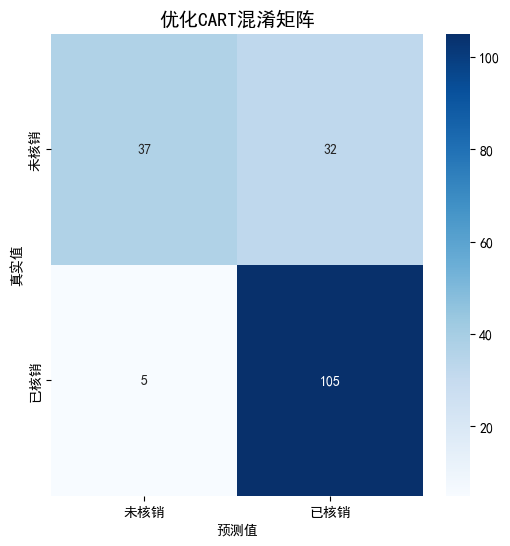


=== 模型性能对比 ===


,准确率,精确率,召回率,F1,AUC
模型,,,,,
优化逻辑回归,79.89%,85.58%,80.91%,0.832,0.883
优化随机森林,80.45%,81.51%,88.18%,0.847,0.867
优化CART,79.33%,76.64%,95.45%,0.850,0.861
优化混合模型,78.21%,76.69%,92.73%,0.840,0.857
优化XGBoost,79.89%,78.03%,93.64%,0.851,0.852
CART(深度=5),77.65%,77.34%,90.00%,0.832,0.830


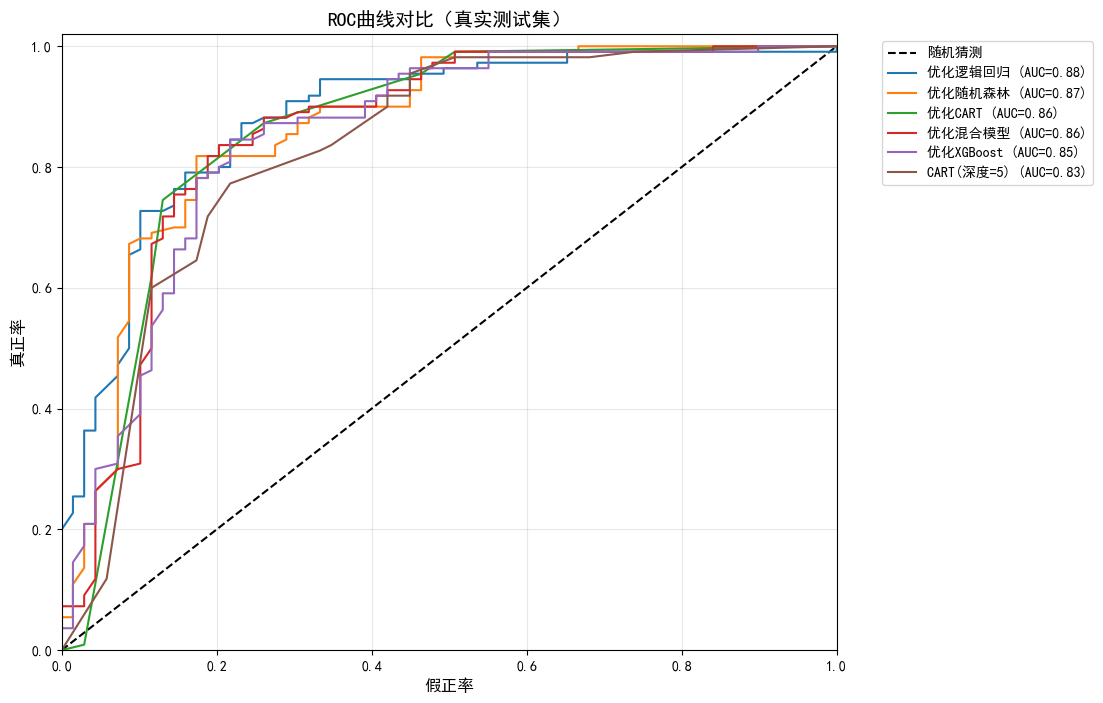

In [41]:
# ======================
# 结果可视化
# ======================

# 混淆矩阵（优化CART）
best_cart = cart_optimizer.best_estimator_
y_pred = best_cart.predict(X_test)
cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=['未核销', '已核销'],
           yticklabels=['未核销', '已核销'])
plt.title('优化CART混淆矩阵', fontsize=14)
plt.xlabel('预测值')
plt.ylabel('真实值')
plt.show()


# 性能对比表格
results_df = pd.DataFrame(results).set_index('模型').sort_values('AUC', ascending=False)

# 设置显示格式
styled_df = results_df.style \
    .format({
        '准确率': '{:.2%}',
        '精确率': '{:.2%}',
        '召回率': '{:.2%}',
        'F1': '{:.3f}',
        'AUC': '{:.3f}'
    }) \
    .background_gradient(subset=['AUC'], cmap='YlGnBu') \
    .background_gradient(subset=['F1'], cmap='YlOrBr') \
    .set_caption('模型性能对比表（按AUC排序）') \
    .set_properties(**{
        'text-align': 'center',
        'font-size': '12pt',
        'min-width': '80px'
    }) \
    .set_table_styles([{
        'selector': 'caption',
        'props': [('font-size', '14pt'), ('font-weight', 'bold')]
    }])

print("\n=== 模型性能对比 ===")
display(styled_df)

# ROC曲线对比
plt.figure(figsize=(10,8))
plt.plot([0, 1], [0, 1], 'k--', label='随机猜测')
for name in results_df.index:
    if name in roc_data:
        fpr, tpr = roc_data[name]
        plt.plot(fpr, tpr, label=f'{name} (AUC={results_df.loc[name, "AUC"]:.2f})')
plt.title('ROC曲线对比（真实测试集）', fontsize=14)
plt.xlabel('假正率', fontsize=12)
plt.ylabel('真正率', fontsize=12)
plt.legend(bbox_to_anchor=(1.05, 1))
plt.grid(alpha=0.3)
plt.xlim(0, 1)
plt.ylim(0, 1.02)
plt.show()

# 3.5 示例预测 

In [59]:
# ======================
# 随机森林示例预测
# ======================
print("\n=== 随机森林示例预测 ===")

# 方案1：从测试集随机抽样真实样本
print("\n=== 真实样本预测验证 ===")
np.random.seed(42)
sample_indices = np.random.choice(X_test.index, size=3, replace=False) # 从测试集X_test的索引中，随机选择3个不重复的索引。
 
for idx in sample_indices:
    try:
        real_sample = X_test.loc[[idx]] # 根据索引idx，从测试集特征矩阵X_test中获取对应的真实样本数据。
        real_label = y_test.loc[idx] # 根据索引idx，从测试集标签向量y_test中获取对应的真实标签

         # predict_proba方法会返回每个样本属于各个类别的概率，[0][1]表示取第一个样本属于第二个类别的概率
        prob = rf_optimizer.best_estimator_.predict_proba(real_sample)[0][1]  # 使用随机森林优化器rf_optimizer中最优的估计器，对当前真实样本进行预测。
        prediction = "已核销" if prob > 0.5 else "未核销"

        print(f"\n真实样本ID：{idx}")
        print(f"特征值：{real_sample.values.tolist()[0]}")
        print(f"实际状态：{'已核销' if real_label == 1 else '未核销'}")
        print(f"预测概率：{prob * 100:.1f}% → 预测结果：{prediction}")
        print("=" * 50)

    except Exception as e:
        print(f"预测错误：{str(e)}")

# 方案2：边界案例测试（概率接近50%的情况）
print("\n=== 边界案例测试 ===")
boundary_cases = [
    {'特征说明': '边界案例1', '数据': [2, 1, 0, 65]},
    {'特征说明': '边界案例2', '数据': [1, 2, 1, 55]}
]

for case in boundary_cases:
    # 从当前边界案例字典中提取特征值列表，并将其作为元素放入一个新的列表中
    # 这是因为后续创建DataFrame时，需要传入二维数据结构
    sample_data = [case['数据']]
    # 使用提取的特征值列表创建一个DataFrame，列名与特征矩阵X的列名相同
    sample_df = pd.DataFrame(sample_data, columns=X.columns)

    try:
        prob = rf_optimizer.best_estimator_.predict_proba(sample_df)[0][1]
        print(f"\n案例：{case['特征说明']}")
        print(f"预测概率：{prob * 100:.1f}%")

    except Exception as e:
        print(f"预测错误：{str(e)}")


=== 随机森林示例预测 ===

=== 真实样本预测验证 ===

真实样本ID：141
特征值：[1, 1, 1, 43]
实际状态：已核销
预测概率：78.2% → 预测结果：已核销

真实样本ID：712
特征值：[2, 2, 3, 42]
实际状态：未核销
预测概率：5.1% → 预测结果：未核销

真实样本ID：375
特征值：[1, 2, 1, 38]
实际状态：已核销
预测概率：83.6% → 预测结果：已核销

=== 边界案例测试 ===

案例：边界案例1
预测概率：37.7%

案例：边界案例2
预测概率：88.0%


In [61]:
# ======================
# 混合模型示例预测
# ======================
print("\n=== 混合模型示例预测 ===")

# 方案1：从测试集随机抽样真实样本
print("\n=== 真实样本预测验证 ===")
np.random.seed(42)
sample_indices = np.random.choice(X_test.index, size=3, replace=False) # 从测试集的索引中随机选择3个不重复的索引

# 遍历每个随机抽取的索引
for idx in sample_indices:
    try:
        # 这里使用双重方括号 [[idx]] 是为了确保获取的数据是一个 DataFrame 格式，便于后续模型处理
        real_sample = X_test.loc[[idx]] # 根据索引从测试集特征矩阵X_test中获取对应的真实样本
        real_label = y_test.loc[idx] # 根据索引从测试集标签向量y_test中获取对应的真实标签
        
        prob = voting_optimizer.best_estimator_.predict_proba(real_sample)[0][1]
        prediction = "已核销" if prob > 0.5 else "未核销"
        
        print(f"\n真实样本ID：{idx}")
        print(f"特征值：{real_sample.values.tolist()[0]}")
        print(f"实际状态：{'已核销' if real_label == 1 else '未核销'}")
        print(f"预测概率：{prob*100:.1f}% → 预测结果：{prediction}")
        print("="*50)
        
    except Exception as e:
        print(f"预测错误：{str(e)}")

# 方案2：边界案例测试（概率接近50%的情况）
print("\n=== 边界案例测试 ===")
boundary_cases = [
    {'特征说明': '边界案例1', '数据': [2, 1, 0, 65]},
    {'特征说明': '边界案例2', '数据': [1, 2, 1, 55]}
]

for case in boundary_cases:
    sample_data = [case['数据']]
    sample_df = pd.DataFrame(sample_data, columns=X.columns)
    
    try:
        prob = voting_optimizer.best_estimator_.predict_proba(sample_df)[0][1]
        print(f"\n案例：{case['特征说明']}")
        print(f"预测概率：{prob*100:.1f}%")
        
    except Exception as e:
        print(f"预测错误：{str(e)}")


=== 混合模型示例预测 ===

=== 真实样本预测验证 ===

真实样本ID：141
特征值：[1, 1, 1, 43]
实际状态：已核销
预测概率：85.1% → 预测结果：已核销

真实样本ID：712
特征值：[2, 2, 3, 42]
实际状态：未核销
预测概率：6.7% → 预测结果：未核销

真实样本ID：375
特征值：[1, 2, 1, 38]
实际状态：已核销
预测概率：86.8% → 预测结果：已核销

=== 边界案例测试 ===

案例：边界案例1
预测概率：42.4%

案例：边界案例2
预测概率：89.4%


In [26]:
from sklearn import tree
# 以文字的形式展示训练的树
print(f'文字形式展示:{models[1]['name']}模型\n{tree.export_text(models[1]['model'],feature_names=list(X.columns),spacing=3,decimals=1)}')

文字形式展示:优化CART模型
|--- Sex <= 1.5
|   |--- Class <= 2.5
|   |   |--- AvgSpending <= 58.5
|   |   |   |--- class: 1
|   |   |--- AvgSpending >  58.5
|   |   |   |--- class: 1
|   |--- Class >  2.5
|   |   |--- AvgSpending <= 165.5
|   |   |   |--- class: 1
|   |   |--- AvgSpending >  165.5
|   |   |   |--- class: 1
|--- Sex >  1.5
|   |--- Class <= 1.5
|   |   |--- AvgSpending <= 38.5
|   |   |   |--- class: 0
|   |   |--- AvgSpending >  38.5
|   |   |   |--- class: 1
|   |--- Class >  1.5
|   |   |--- AvgSpending <= 33.5
|   |   |   |--- class: 1
|   |   |--- AvgSpending >  33.5
|   |   |   |--- class: 0



In [27]:
# ======================
# 逻辑回归模型解释
# ======================
# 获取优化后的逻辑回归模型
logreg_best_model = logreg_optimizer.best_estimator_

# 获取模型的系数（权重）和截距
coefficients = logreg_best_model.coef_[0]  # 逻辑回归的系数
intercept = logreg_best_model.intercept_[0]  # 逻辑回归的截距

# 获取特征名称
feature_names = X.columns.tolist()

# 将特征名称和对应的系数组合成字典
feature_importance = dict(zip(feature_names, coefficients))

# 打印模型参数
print("\n逻辑回归模型解释：")
print(f"模型截距（bias）: {intercept:.4f}")
print("特征权重（系数）: ")
for feature, importance in feature_importance.items():
    print(f"  {feature}: {importance:.4f}")

# 按权重绝对值排序（绝对值越大，影响越大）
sorted_features = sorted(feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

# 输出排序后的特征重要性
print("\n按权重绝对值排序的特征影响：")
for feature, importance in sorted_features:
    # 解释正负权重的意义
    impact = "正向影响" if importance > 0 else "负向影响"
    print(f"{feature}: 权重 = {importance:.4f} （{impact}）")


逻辑回归模型解释：
模型截距（bias）: 2.2420
特征权重（系数）: 
  Sex: -1.5746
  Age: 0.5647
  Class: -0.5467
  AvgSpending: -0.0016

按权重绝对值排序的特征影响：
Sex: 权重 = -1.5746 （负向影响）
Age: 权重 = 0.5647 （正向影响）
Class: 权重 = -0.5467 （负向影响）
AvgSpending: 权重 = -0.0016 （负向影响）


逻辑回归系数分析：
1. 男性相比女性核销率明显较低
2. 中老年比中青年核销率稍高
3. 低端产品比高端产品核销率稍高